In [ ]:
# Core
import numpy as np
import pandas as pd

# ML & CV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# XGBoost
!pip -q install xgboost
from xgboost import XGBClassifier

RANDOM_STATE = 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Eye-tracking--main/EMS_FEATURES_FINAL.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Label distribution:")
print(df["LABEL"].value_counts())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (160, 11)
Columns: ['SUBJECT_ID', 'PROP_LONG_FIX', 'FIX_COUNT', 'SAC_COUNT', 'PUPIL_DERIV_STD', 'PUPIL_STD', 'PUPIL_CV', 'MEAN_DURATION', 'HM_ENTROPY', 'SAC_MEAN_AMP', 'LABEL']
Label distribution:
LABEL
0    80
1    80
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# ===== FEATURE LIST =====
FEATURES = [
    'PROP_LONG_FIX', 'FIX_COUNT', 'SAC_COUNT',
    'PUPIL_DERIV_STD', 'PUPIL_STD', 'PUPIL_CV',
    'MEAN_DURATION', 'HM_ENTROPY', 'SAC_MEAN_AMP'
]

x = df[FEATURES].values
y = df["LABEL"].values
ids = df["SUBJECT_ID"].values

print("Total samples:", len(y))
print("Label distribution:", dict(zip(*np.unique(y, return_counts=True))))

x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(
    x, y, ids,
    test_size=0.30,
    random_state=42,
    stratify=y
)
print("Train size:", x_train.shape[0])
print("Test size :", x_test.shape[0])
print("Train label distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test label distribution :", dict(zip(*np.unique(y_test, return_counts=True))))

Total samples: 160
Label distribution: {np.int64(0): np.int64(80), np.int64(1): np.int64(80)}
Train size: 112
Test size : 48
Train label distribution: {np.int64(0): np.int64(56), np.int64(1): np.int64(56)}
Test label distribution : {np.int64(0): np.int64(24), np.int64(1): np.int64(24)}


In [ ]:
cv = StratifiedKFold(
    n_splits=4,
    shuffle=True,
    random_state=RANDOM_STATE
)

In [ ]:
def run_grid_search(name, pipeline, param_grid, x, y, cv):
    print(f"\n===== {name} =====")

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    gs.fit(x, y)

    print("Best ROC-AUC :", gs.best_score_)
    print("Best params  :", gs.best_params_)

    return gs

In [ ]:
rf_pipe = Pipeline([
    ("clf", RandomForestClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

rf_param = {
    "clf__n_estimators": [300, 500],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_leaf": [1, 3, 5]
}

gs_rf = run_grid_search(
    name="Random Forest",
    pipeline=rf_pipe,
    param_grid=rf_param,
    x=x_train,
    y=y_train,
    cv=cv
)


===== Random Forest =====
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best ROC-AUC : 0.8545918367346939
Best params  : {'clf__max_depth': None, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 300}


In [ ]:
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

svm_param = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.1]
}

gs_svm = run_grid_search(
    name="SVM (RBF)",
    pipeline=svm_pipe,
    param_grid=svm_param,
    x=x_train,
    y=y_train,
    cv=cv
)


===== SVM (RBF) =====
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best ROC-AUC : 0.8831249999999999
Best params  : {'clf__C': 10, 'clf__gamma': 0.01}


In [ ]:
xgb_pipe = Pipeline([
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

xgb_param = {
    "clf__n_estimators": [300, 500],
    "clf__max_depth": [3, 5],
    "clf__learning_rate": [0.03, 0.05],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0]
}

gs_xgb = run_grid_search(
    name="XGBoost",
    pipeline=xgb_pipe,
    param_grid=xgb_param,
    x=x_train,
    y=y_train,
    cv=cv
)


===== XGBoost =====
Fitting 4 folds for each of 32 candidates, totalling 128 fits
Best ROC-AUC : 0.8456632653061225
Best params  : {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.03, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__subsample': 0.8}


In [ ]:
log_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight="balanced",
        solver="liblinear",
        random_state=RANDOM_STATE
    ))
])

log_param = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l1", "l2"]
}

gs_log = run_grid_search(
    name="Logistic Regression",
    pipeline=log_pipe,
    param_grid=log_param,
    x=x_train,
    y=y_train,
    cv=cv
)


===== Logistic Regression =====
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best ROC-AUC : 0.8813775510204082
Best params  : {'clf__C': 10, 'clf__penalty': 'l1'}


In [ ]:
# ----- LDA Pipeline -----
lda_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearDiscriminantAnalysis())
])
lda_param = [
    {"clf__solver": ["svd"],  "clf__shrinkage": [None]},
    {"clf__solver": ["lsqr"], "clf__shrinkage": [None, "auto"]},
]

gs_lda = run_grid_search(
    name="LDA",
    pipeline=lda_pipe,
    param_grid=lda_param,
    x=x_train,
    y=y_train,
    cv=cv
)



===== LDA =====
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Best ROC-AUC : 0.8635204081632654
Best params  : {'clf__shrinkage': None, 'clf__solver': 'svd'}


In [ ]:
print("Saving best models...")

best_rf  = gs_rf.best_estimator_
best_svm = gs_svm.best_estimator_
best_xgb = gs_xgb.best_estimator_
best_log = gs_log.best_estimator_
best_lda = gs_lda.best_estimator_

print("Done. Available models:")
print("best_rf  :", type(best_rf))
print("best_svm :", type(best_svm))
print("best_xgb :", type(best_xgb))
print("best_log :", type(best_log))
print("best_lda :", type(best_lda))


Saving best models...
Done. Available models:
best_rf  : <class 'sklearn.pipeline.Pipeline'>
best_svm : <class 'sklearn.pipeline.Pipeline'>
best_xgb : <class 'sklearn.pipeline.Pipeline'>
best_log : <class 'sklearn.pipeline.Pipeline'>
best_lda : <class 'sklearn.pipeline.Pipeline'>


=== Confusion Matrix on TRAIN SET (112 samples) ===

Random Forest


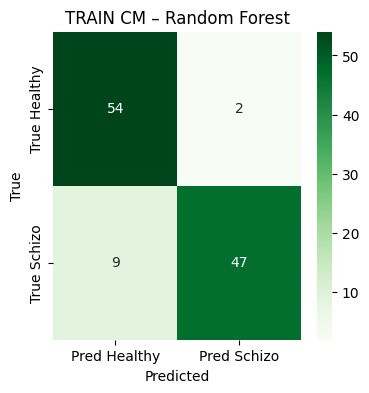


SVM RBF


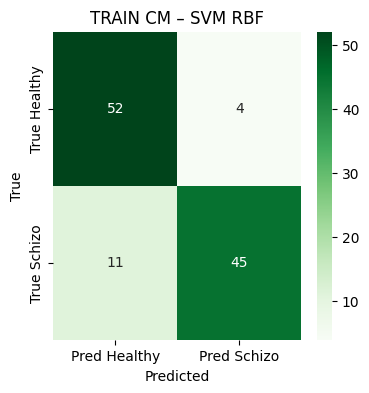


XGBoost


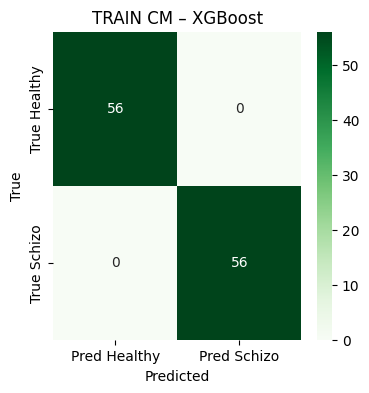


Logistic Regression


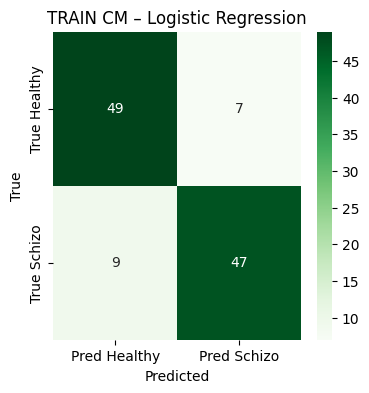


LDA


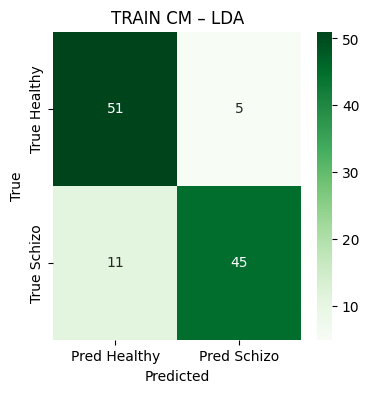

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=["Pred Healthy", "Pred Schizo"],
        yticklabels=["True Healthy", "True Schizo"]
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("=== Confusion Matrix on TRAIN SET (112 samples) ===")

for name, model in models.items():
    print(f"\n{name}")

    p_train = predict_proba_safe(model, X_train)
    y_pred_train = (p_train >= 0.5).astype(int)

    cm_train = confusion_matrix(y_train, y_pred_train, labels=[0, 1])
    plot_cm(cm_train, f"TRAIN CM – {name}")


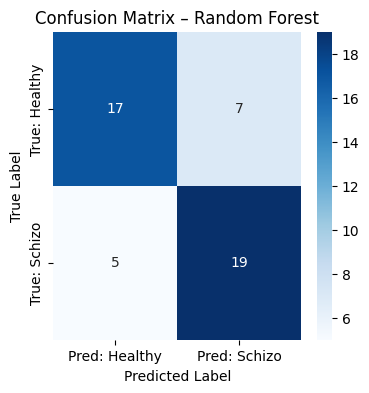

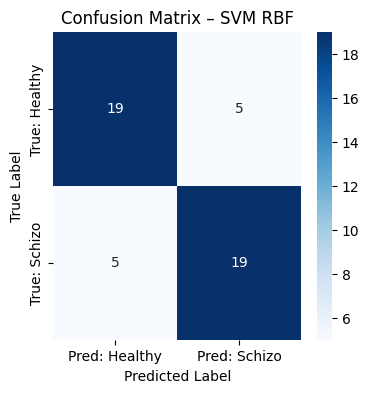

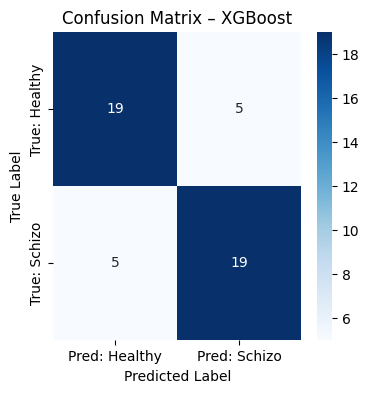

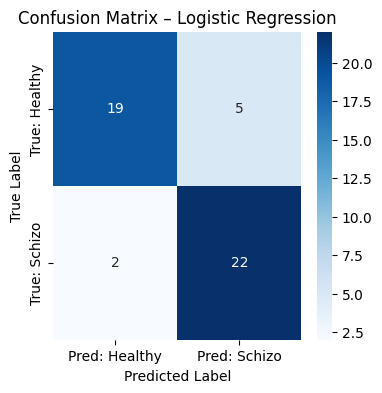

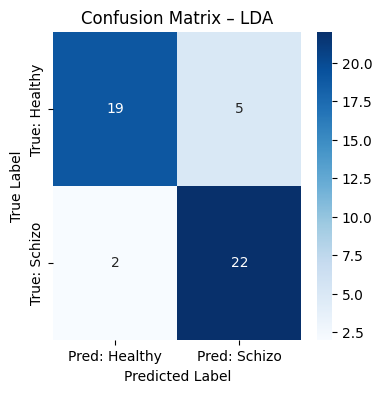

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred: Healthy", "Pred: Schizo"],
        yticklabels=["True: Healthy", "True: Schizo"]
    )
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

for name, model in models.items():
    p = predict_proba_safe(model, x_test)
    y_pred = (p >= 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    plot_confusion_matrix(cm, f"Confusion Matrix – {name}")


In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    precision_score, recall_score
)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_proba_safe(model, x):
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(x)
        if proba.shape[1] == 2:
            return proba[:, 1]
        return proba.ravel()

    if hasattr(model, "decision_function"):
        scores = model.decision_function(x)
        return sigmoid(scores)

    raise ValueError("Model has neither predict_proba nor decision_function")

models = {
    "Random Forest": best_rf,
    "SVM RBF": best_svm,
    "XGBoost": best_xgb,
    "Logistic Regression": best_log,
    "LDA": best_lda,
}

results = {}
preds = {}
probs = {}

for name, model in models.items():
    p = predict_proba_safe(model, x_test)
    y_pred = (p >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    prec = precision_score(y_test, y_pred, zero_division=0)
    sens = recall_score(y_test, y_pred, zero_division=0)  # sensitivity = recall of positive class

    if len(np.unique(y_test)) < 2:
        auc = None
    else:
        auc = roc_auc_score(y_test, p)

    results[name] = {
        "Accuracy": acc,
        "F1": f1,
        "Precision": prec,
        "Sensitivity": sens,
        "ROC-AUC": auc
    }
    preds[name] = y_pred
    probs[name] = p

    print(f"\n=== {name} ===")
    print(f"Accuracy    : {acc:.4f}")
    print(f"Precision   : {prec:.4f}")
    print(f"Sensitivity : {sens:.4f}")
    print(f"F1-score    : {f1:.4f}")
    print(f"ROC-AUC     : {'N/A (single class in y_test)' if auc is None else f'{auc:.4f}'}")
    print("\nReport:")
    print(classification_report(
        y_test, y_pred,
        labels=[0, 1],
        target_names=["HEALTHY", "SCHIZO"],
        zero_division=0
    ))



=== Random Forest ===
Accuracy    : 0.7500
Precision   : 0.7308
Sensitivity : 0.7917
F1-score    : 0.7600
ROC-AUC     : 0.8281

Report:
              precision    recall  f1-score   support

     HEALTHY       0.77      0.71      0.74        24
      SCHIZO       0.73      0.79      0.76        24

    accuracy                           0.75        48
   macro avg       0.75      0.75      0.75        48
weighted avg       0.75      0.75      0.75        48


=== SVM RBF ===
Accuracy    : 0.7917
Precision   : 0.7917
Sensitivity : 0.7917
F1-score    : 0.7917
ROC-AUC     : 0.9062

Report:
              precision    recall  f1-score   support

     HEALTHY       0.79      0.79      0.79        24
      SCHIZO       0.79      0.79      0.79        24

    accuracy                           0.79        48
   macro avg       0.79      0.79      0.79        48
weighted avg       0.79      0.79      0.79        48


=== XGBoost ===
Accuracy    : 0.7917
Precision   : 0.7917
Sensitivity : 0.791

Features: ['PROP_LONG_FIX', 'FIX_COUNT', 'SAC_COUNT', 'PUPIL_DERIV_STD', 'PUPIL_STD', 'PUPIL_CV', 'MEAN_DURATION', 'HM_ENTROPY', 'SAC_MEAN_AMP']


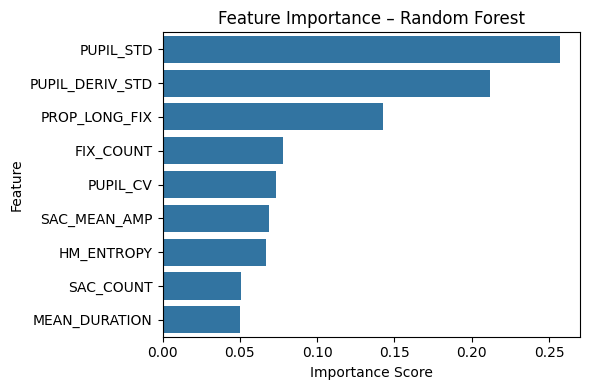

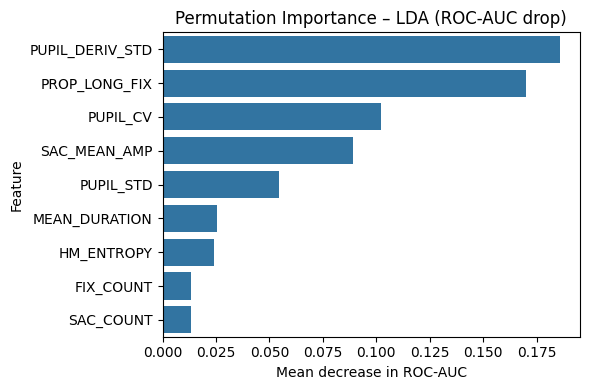

,feature,importance,std
3,PUPIL_DERIV_STD,0.186007,0.048163
0,PROP_LONG_FIX,0.169896,0.054022
5,PUPIL_CV,0.102326,0.049883
8,SAC_MEAN_AMP,0.089306,0.038647
4,PUPIL_STD,0.054479,0.023382
6,MEAN_DURATION,0.025312,0.019148
7,HM_ENTROPY,0.024132,0.019315
1,FIX_COUNT,0.013299,0.018244
2,SAC_COUNT,0.013299,0.018244


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

feature_names = FEATURES
print("Features:", feature_names)
rf_clf = best_rf.named_steps["clf"]

rf_importances = rf_clf.feature_importances_
rf_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=rf_imp_df,
    x="importance",
    y="feature",
)
plt.title("Feature Importance – Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

rf_imp_df

model = best_lda

x_te = x_test
y_te = y_test

result = permutation_importance(
    model,
    x_te,
    y_te,
    n_repeats=50,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

perm_imp = result.importances_mean
perm_std = result.importances_std

perm_df = pd.DataFrame({
    "feature": feature_names,
    "importance": perm_imp,
    "std": perm_std
}).sort_values("importance", ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=perm_df,
    x="importance",
    y="feature"
)
plt.title("Permutation Importance – LDA (ROC-AUC drop)")
plt.xlabel("Mean decrease in ROC-AUC")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

perm_df
